In [15]:
import jax.numpy as jnp
import numpy as np

In [2]:
x=jnp.array([1, 2, 3])

# Just In Time Compilation


In [12]:
def norm(x):
    x=x-x.mean(0)
    return x/x.std(0)

In [13]:
from jax import jit
norm_jit = jit(norm)

In [17]:
np.random.seed(0)
X=jnp.array(np.random.randn(100, 10))
np.allclose(norm(x), norm_jit(x))  # Check if the JIT compiled function gives the same result

True

In [18]:
%timeit norm(x).block_until_ready()
%timeit norm_jit(x).block_until_ready()

27.9 μs ± 146 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.99 μs ± 11.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
@jit
def f(x,y):
    print("running f():")
    print(f" {x}")
    print(f" {y}")
    result = jnp.dot(x+1,y+1)
    print(f" {result = }")
    return result

x=np.random.randn(3,4)
y=np.random.randn(4)
f(x,y)

running f():
 JitTracer<float32[3,4]>
 JitTracer<float32[4]>
 result = JitTracer<float32[3]>


Array([6.8819385, 4.7532573, 4.52822  ], dtype=float32)

In [20]:
x2=np.random.randn(3,4)
y2=np.random.randn(4)
f(x2,y2)

Array([3.8131344, 5.1187015, 5.7350388], dtype=float32)

In [22]:
from jax import make_jaxpr

def f(x, y):
  return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0:f32[]
    d:f32[4] = add b 1.0:f32[]
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }

## `jax.grad` & `jax.jacobian`

In [23]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


In [24]:
def first_finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


In [25]:
from jax import jacobian
print(jacobian(jnp.exp)(x_small))

[[1.        0.        0.       ]
 [0.        2.7182817 0.       ]
 [0.        0.        7.389056 ]]


In [28]:
x_small

Array([0., 1., 2.], dtype=float32)

## VMAP
* automatic vectorisation
* can be composed with jit to make effecient vecotrised code


In [29]:
from jax import random

key = random.key(1701)
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)

In [30]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
375 μs ± 86.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
27.3 μs ± 2.22 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
33.1 μs ± 267 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## pytree

In [44]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x11d988be0>]      has 3 leaves: [1, 'a', <object object at 0x11d988be0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [45]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree.map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [46]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [48]:
# check the shapes of the parameters
jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [51]:
# Define the forward pass.
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

# Define the loss function.
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

# Set the learning rate.
LEARNING_RATE = 0.0001

# Using the stochastic gradient descent, define the parameter update function.
# Apply `@jax.jit` for JIT compilation (speed).
@jax.jit
def update(params, x, y):
  # Calculate the gradients with `jax.grad`.
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of many JAX functions that has
  # built-in support for pytrees.
  # This is useful - you can apply the SGD update using JAX pytree utilities.
  return jax.tree.map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

control flow understanding

In [54]:
@jit
def f_fail(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

def f_success(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f_success = jit(f_success, static_argnames='x')

print(f_success(2.))

12.0


In [68]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

12.0
-4.0


In [63]:
from matplotlib import pyplot as plt

In [65]:
x=jnp.arange(0, 10, 0.1)

In [ ]:
import jax
import jax.numpy as jnp
from jax import vmap

def f_jax_cond(x):
  # Use jax.lax.cond for differentiable conditional logic
  return jax.lax.cond(x < 3,   # Predicate (condition)
                      lambda val: 3. * val ** 2, # True branch function
                      lambda val: -4. * val,     # False branch function
                      x) # Operand(s) passed to both branches

# Test with vmap
batched_x = jnp.array([1., 2., 3., 4., 5.])
result = vmap(f_jax_cond)(batched_x)

print(result)
# Expected output: [ 3.  12. -12. -16. -20.]
# (3.*1**2=3, 3.*2**2=12, -4.*3=-12, -4.*4=-16, -4.*5=-20)

[  3.  12. -12. -16. -20.]


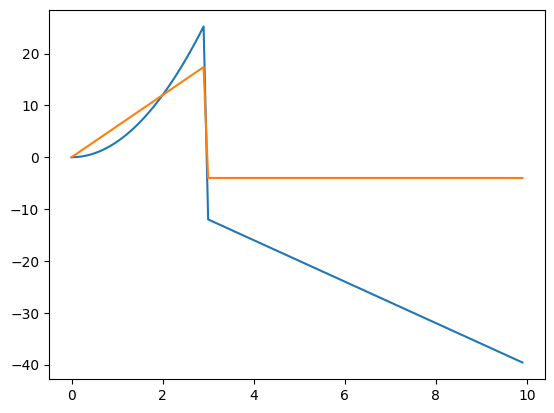

In [75]:
plt.plot(x,vmap(f_jax_cond)(x))
plt.plot(x,vmap(grad(f_jax_cond))(x))

In [79]:
np.testing.assert_allclose(
    vmap(grad(f_jax_cond))(batched_x),

SyntaxError: incomplete input (2779829003.py, line 2)